In [1]:
from pyomo.environ import ( Constraint,
                            Var,
                            ConcreteModel,
                            Expression,
                            Objective,
                            SolverFactory,
                            TransformationFactory,
                            value)
from idaes.core import FlowsheetBlock
from pyomo.network import Arc, SequentialDecomposition
import idaes.logger as idaeslog
import matplotlib.pyplot as plt

In [2]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default = {"dynamic": False})

In [3]:
from idaes.generic_models.unit_models import Flash

In [4]:
from idaes.generic_models.unit_models.pressure_changer import ThermodynamicAssumption

In [5]:
import test_etoh_prop_pkg_works as thermo_props

In [6]:
m.fs.thermo_paras = thermo_props.ETOHParameterBlock()

In [7]:
m.fs.flash = Flash(default= {"property_package": m.fs.thermo_paras})

In [8]:
from idaes.core.util.model_statistics import degrees_of_freedom
print("DOF = ", degrees_of_freedom(m))

DOF =  10


In [9]:
m.fs.flash.inlet.flow_mol_phase_comp[0, "Vap", "ethanol"].fix(1e-5)
m.fs.flash.inlet.flow_mol_phase_comp[0, "Vap", "water"].fix(1e-5)
m.fs.flash.inlet.flow_mol_phase_comp[0, "Vap", "CO2"].fix(0.04)
m.fs.flash.inlet.flow_mol_phase_comp[0, "Liq", "ethanol"].fix(0.04)
m.fs.flash.inlet.flow_mol_phase_comp[0, "Liq", "water"].fix(0.92)
m.fs.flash.inlet.flow_mol_phase_comp[0, "Liq", "CO2"].fix(1e-5)

m.fs.flash.inlet.temperature.fix(305)
m.fs.flash.inlet.pressure.fix(101325)

m.fs.flash.heat_duty.fix(0)
m.fs.flash.deltaP.fix(0)

In [10]:
print("DOF = ", degrees_of_freedom(m))

DOF =  0


In [11]:
m.fs.flash.initialize(outlvl=idaeslog.INFO)

2021-05-04 11:43:20 [INFO] idaes.init.fs.flash.control_volume: Initialization Complete
2021-05-04 11:43:20 [INFO] idaes.init.fs.flash: Initialization Complete: optimal - Optimal Solution Found


In [12]:
solver = SolverFactory('ipopt')

status = solver.solve(m, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

print('Pressure = ', value(m.fs.flash.vap_outlet.pressure[0]))

print()
print('Output from display:')
m.fs.flash.vap_outlet.display()
m.fs.flash.liq_outlet.display()

In [13]:
m.fs.flash.report()




Unit : fs.flash                                                            Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value  : Fixed : Bounds
          Heat Duty : 0.0000 :  True : (None, None)
    Pressure Change : 0.0000 :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                              Inlet    Vapor Outlet  Liquid Outlet
    flow_mol_phase_comp ('Liq', 'ethanol')   0.040000   1.0000e-08      0.039812  
    flow_mol_phase_comp ('Liq', 'water')      0.92000   1.0000e-08       0.91816  
    flow_mol_phase_comp ('Liq', 'CO2')     1.0000e-05   1.0000e-08    9.5797e-07  
    flow_mol_phase_comp ('Vap', 'ethanol') 1.0000e-05   0.00019773    1.0000e-08  
    flow_mol_phase_comp ('Vap', 'water')   1.0000e-05    0.0018547    1.0000e-08  
    flow_mol_phase_comp ('Vap', 'CO2') 

## Adding the second flash

In [14]:
m.fs.flash2 = Flash(default= {"property_package": m.fs.thermo_paras,
                                "has_heat_transfer": True})

In [15]:
m.fs.s01 = Arc(source=m.fs.flash.liq_outlet, destination = m.fs.flash2.inlet)

In [16]:
TransformationFactory("network.expand_arcs").apply_to(m)

In [17]:
m.fs.flash2.heat_duty.fix(10000)
m.fs.flash2.deltaP.fix(0)

In [18]:
print("DOF = ", degrees_of_freedom(m))

DOF =  0


In [19]:
m.fs.flash2.initialize(outlvl=idaeslog.INFO)

2021-04-21 16:54:44 [INFO] idaes.init.fs.flash2.control_volume: Initialization Complete
2021-04-21 16:54:44 [INFO] idaes.init.fs.flash2: Initialization Complete: optimal - Optimal Solution Found


In [20]:
solver = SolverFactory('ipopt')

status = solver.solve(m, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [21]:
m.fs.flash2.report()


Unit : fs.flash2                                                           Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value  : Fixed : Bounds
          Heat Duty : 10000. :  True : (None, None)
    Pressure Change : 0.0000 :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                              Inlet    Vapor Outlet  Liquid Outlet
    flow_mol_phase_comp ('Liq', 'ethanol')   0.039812   1.0000e-08      0.039374  
    flow_mol_phase_comp ('Liq', 'water')      0.91816   1.0000e-08       0.91350  
    flow_mol_phase_comp ('Liq', 'CO2')     9.5797e-07   1.0000e-08    9.5287e-07  
    flow_mol_phase_comp ('Vap', 'ethanol') 1.0000e-08   0.00043789    1.0000e-08  
    flow_mol_phase_comp ('Vap', 'water')   1.0000e-08    0.0046582    1.0000e-08  
    flow_mol_phase_comp ('Vap', 'CO2') 

## Plotting

Simulating with Q =  50000.0
... solve successful.
Simulating with Q =  54545.454545454544
... solve successful.
Simulating with Q =  59090.90909090909
... solve successful.
Simulating with Q =  63636.36363636363
... solve successful.
Simulating with Q =  68181.81818181818
... solve successful.
Simulating with Q =  72727.27272727272
... solve successful.
Simulating with Q =  77272.72727272726
... solve successful.
Simulating with Q =  81818.18181818182
... solve successful.
Simulating with Q =  86363.63636363635
... solve successful.
Simulating with Q =  90909.09090909091
... solve successful.
Simulating with Q =  95454.54545454544
... solve successful.
Simulating with Q =  100000.0
... solve successful.
Simulating with Q =  104545.45454545454
... solve successful.
Simulating with Q =  109090.90909090909
... solve successful.
Simulating with Q =  113636.36363636363
... solve successful.
Simulating with Q =  118181.81818181818
... solve successful.
Simulating with Q =  122727.2727272727

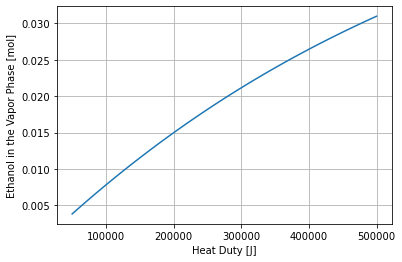

In [77]:
# import the solve_successful checking function from workshop tools
from workshoptools import solve_successful

# Todo: import numpy
import numpy as np

# create the empty lists to store the results that will be plotted
Q = []
V = []

# re-initialize model
#m.fs.flash.initialize(outlvl=idaeslog.WARNING)
m.fs.flash2.initialize(outlvl=idaeslog.WARNING)

# Todo: Write the for loop specification using numpy's linspace
for duty in np.linspace(50000, 500000, 100):
    # fix the heat duty
    m.fs.flash2.heat_duty.fix(duty)
    
    # append the value of the duty to the Q list
    Q.append(duty)
    
    # print the current simulation
    print("Simulating with Q = ", value(m.fs.flash2.heat_duty[0]))

    # Solve the model
    status = solver.solve(m)
    
    # append the value for vapor fraction if the solve was successful
    if solve_successful(status):
        V.append(value(m.fs.flash2.vap_outlet.flow_mol_phase_comp[0, "Vap", "ethanol"]))
        print('... solve successful.')
    else:
        V.append(0.0)
        print('... solve failed.')
    
# Create and show the figure
plt.figure("Vapor Fraction Flash2")
plt.plot(Q, V)
plt.grid()
plt.xlabel("Heat Duty [J]")
plt.ylabel("Ethanol in the Vapor Phase [mol]")
plt.show()

In [35]:
vap_ethanol = value(m.fs.flash2.vap_outlet.flow_mol_phase_comp[0, "Vap", "ethanol"])
vap_ethanol

0.030984526197125335

In [36]:
vap_water = value(m.fs.flash2.vap_outlet.flow_mol_phase_comp[0, "Vap", "water"])
vap_water

0.5664978603508012

In [38]:
purity = vap_ethanol / (vap_water + vap_ethanol)
purity

0.051858476324540055

In [28]:
m.fs.flash2.report()


Unit : fs.flash2                                                           Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value  : Fixed : Bounds
          Heat Duty : 10000. :  True : (None, None)
    Pressure Change : 0.0000 :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                              Inlet    Vapor Outlet  Liquid Outlet
    flow_mol_phase_comp ('Liq', 'ethanol')   0.039812   1.0000e-08      0.039374  
    flow_mol_phase_comp ('Liq', 'water')      0.91816   1.0000e-08       0.91350  
    flow_mol_phase_comp ('Liq', 'CO2')     9.5797e-07   1.0000e-08    9.5287e-07  
    flow_mol_phase_comp ('Vap', 'ethanol') 1.0000e-08   0.00043789    1.0000e-08  
    flow_mol_phase_comp ('Vap', 'water')   1.0000e-08    0.0046582    1.0000e-08  
    flow_mol_phase_comp ('Vap', 'CO2') 

Simulating with Q =  1000.0
Vap_out temperature Tout =  306.1374542280864
Purity =  0.5
... solve successful.
Simulating with Q =  6040.404040404041
Vap_out temperature Tout =  318.2159570076473
Purity =  0.08629802533953693
... solve successful.
Simulating with Q =  11080.808080808081
Vap_out temperature Tout =  371.1462101262265
Purity =  0.08582420518928419
... solve successful.
Simulating with Q =  16121.212121212122
Vap_out temperature Tout =  371.15375960306875
Purity =  0.0853531164787514
... solve successful.
Simulating with Q =  21161.616161616163
Vap_out temperature Tout =  371.1610730578918
Purity =  0.08488473534401025
... solve successful.
Simulating with Q =  26202.020202020205
Vap_out temperature Tout =  371.16833034776494
Purity =  0.08441906118250106
... solve successful.
Simulating with Q =  31242.424242424244
Vap_out temperature Tout =  371.17554039055904
Purity =  0.08395609398583366
... solve successful.
Simulating with Q =  36282.82828282828
Vap_out temperature To

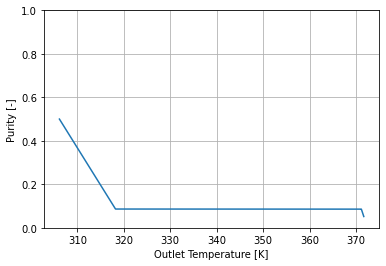

In [75]:
# import the solve_successful checking function from workshop tools
from workshoptools import solve_successful

# Todo: import numpy
import numpy as np

# create the empty lists to store the results that will be plotted
Q = [] # heat duty of flash2
T = [] # vap outlet temperature
P = [] # purity in vapor phase

# re-initialize model
m.fs.flash2.initialize(outlvl=idaeslog.WARNING)

# Todo: Write the for loop specification using numpy's linspace
for duty in np.linspace(1000, 500000, 100):
    # fix the heat duty
    m.fs.flash2.heat_duty.fix(duty)
    
    # append the value of the duty to the Q list
    Q.append(duty)

    # append vap_out temperature to the T list
    tout = value(m.fs.flash2.vap_outlet.temperature[0])
    T.append(tout)
    
    # print the current simulation
    print("Simulating with Q = ", value(m.fs.flash2.heat_duty[0]))
    print("Vap_out temperature Tout = ", tout)

    # Solve the model
    status = solver.solve(m)
    
    # append the value for purity if the solve was successful
    if solve_successful(status):
        vap_ethanol = value(m.fs.flash2.vap_outlet.flow_mol_phase_comp[0, "Vap", "ethanol"])
        vap_water = value(m.fs.flash2.vap_outlet.flow_mol_phase_comp[0, "Vap", "water"])
        purity = vap_ethanol / (vap_water + vap_ethanol)
        P.append(purity)
        print("Purity = ", purity)
        print('... solve successful.')
    else:
        P.append(0.0)
        print('... solve failed.')
    
# Create and show the figure
plt.figure("Purity (Ethanol in Vapor Phase)")
plt.plot(T, P)
plt.grid()
plt.ylim(0, 1)
plt.xlabel("Outlet Temperature [K]")
plt.ylabel("Purity [-]")
plt.show()

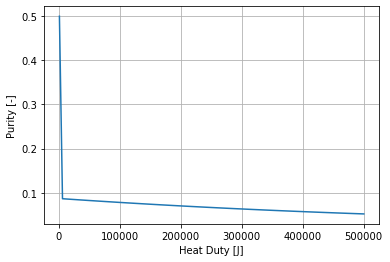

In [76]:
plt.figure("Purity wrt heat duty")
plt.plot(Q, P)
plt.grid()
plt.xlabel("Heat Duty [J]")
plt.ylabel("Purity [-]")
plt.show()

In [54]:
m.fs.flash2.report()


Unit : fs.flash2                                                           Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value      : Fixed : Bounds
          Heat Duty : 1.0000e+05 :  True : (None, None)
    Pressure Change :     0.0000 :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                              Inlet    Vapor Outlet  Liquid Outlet
    flow_mol_phase_comp ('Liq', 'ethanol')   0.039812   1.0000e-08      0.031994  
    flow_mol_phase_comp ('Liq', 'water')      0.91816   1.0000e-08       0.82562  
    flow_mol_phase_comp ('Liq', 'CO2')     9.5797e-07   1.0000e-08    8.5762e-07  
    flow_mol_phase_comp ('Vap', 'ethanol') 1.0000e-08    0.0078182    1.0000e-08  
    flow_mol_phase_comp ('Vap', 'water')   1.0000e-08     0.092531    1.0000e-08  
    flow_mol_phase_comp ('V

In [46]:
value(m.fs.flash2.vap_outlet.temperature[0])

371.6750859898981

In [47]:
        vap_etoh = value(m.fs.flash2.vap_outlet.flow_mol_phase_comp[0,"Vap","ethanol"])
        vap_water = value(m.fs.flash2.vap_outlet.flow_mol_phase_comp[0,"Vap","water"])
        purity = vap_etoh / (vap_etoh + vap_water)

In [48]:
vap_water

0.5664978603508012

In [49]:
vap_etoh

0.03098452619712533

In [50]:
m.fs.flash.report()


Unit : fs.flash                                                            Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value  : Fixed : Bounds
          Heat Duty : 0.0000 :  True : (None, None)
    Pressure Change : 0.0000 :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                              Inlet    Vapor Outlet  Liquid Outlet
    flow_mol_phase_comp ('Liq', 'ethanol')   0.040000   1.0000e-08      0.039812  
    flow_mol_phase_comp ('Liq', 'water')      0.92000   1.0000e-08       0.91816  
    flow_mol_phase_comp ('Liq', 'CO2')     1.0000e-05   1.0000e-08    9.5797e-07  
    flow_mol_phase_comp ('Vap', 'ethanol') 1.0000e-05   0.00019773    1.0000e-08  
    flow_mol_phase_comp ('Vap', 'water')   1.0000e-05    0.0018547    1.0000e-08  
    flow_mol_phase_comp ('Vap', 'CO2') 

## LCA with Brightway2

In [3]:
import LCA_calc as LCA

In [ ]:
# Heat duty & sugar input of flashes
heat_duty = value(m.fs.flash2.heat_duty[0]) # Unit: J
sugar_input = 1.9   # 1 kg glucose input per 1 kg Ethanol output

In [4]:
LCA.LCIA("heat_MJ", "CH", "Human Toxicity")

LCIA data successfully imported.


0.000483100758016325